In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.contrib.eager as tfe
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
sns.set(color_codes=True)
import os
%matplotlib inline
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
tf.enable_eager_execution()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Import the dataset

In [0]:
df  = pd.read_csv('Data/jena_climate_2016.csv', delimiter = ',')
df = df.drop_duplicates()
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
368291,01.01.2016 00:00:00,999.08,-0.01,273.22,-0.44,96.9,6.10,5.91,0.19,3.69,5.92,1271.32,1.16,2.04,192.4
368292,01.01.2016 00:10:00,999.03,0.01,273.25,-0.41,97.0,6.11,5.93,0.18,3.70,5.94,1271.16,1.01,2.12,211.6
368293,01.01.2016 00:20:00,999.07,0.06,273.29,-0.36,97.0,6.13,5.95,0.18,3.71,5.96,1270.97,0.80,1.52,203.8
368294,01.01.2016 00:30:00,999.09,0.07,273.30,-0.36,96.9,6.14,5.95,0.19,3.71,5.96,1270.93,0.77,1.64,184.2
368295,01.01.2016 00:40:00,999.09,-0.05,273.18,-0.50,96.8,6.09,5.89,0.19,3.68,5.90,1271.54,0.84,1.92,200.1


In [0]:
split_size = 40000
names = list(df.columns)

Remove outliers using Interquartile range of the data

In [0]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
p (mbar),1.000000,-0.147043,-0.235182,-0.140024,0.063031,-0.119389,-0.120793,-0.075557,-0.136008,-0.136141,0.424017,-0.111431,-0.100347,-0.083486
T (degC),-0.147043,1.000000,0.995965,0.924596,-0.449647,0.977183,0.902085,0.743207,0.901774,0.902103,-0.957659,0.016563,0.051471,0.054304
Tpot (K),-0.235182,0.995965,1.000000,0.921222,-0.447588,0.971132,0.897464,0.737215,0.898554,0.898889,-0.979456,0.026509,0.059775,0.060901
Tdew (degC),-0.140024,0.924596,0.921222,1.000000,-0.078832,0.894089,0.981192,0.455399,0.980761,0.981062,-0.895417,-0.088431,-0.074683,0.037458
rh (%),0.063031,-0.449647,-0.447588,-0.078832,1.000000,-0.455969,-0.066074,-0.858320,-0.066394,-0.066531,0.409985,-0.256908,-0.316719,-0.065735
VPmax (mbar),-0.119389,0.977183,0.971132,0.894089,-0.455969,1.000000,0.904169,0.787922,0.903921,0.903998,-0.924571,0.000179,0.029795,0.037358
VPact (mbar),-0.120793,0.902085,0.897464,0.981192,-0.066074,0.904169,1.000000,0.449373,0.999852,0.999854,-0.867178,-0.110318,-0.101428,0.027493
VPdef (mbar),-0.075557,0.743207,0.737215,0.455399,-0.858320,0.787922,0.449373,1.000000,0.449067,0.449225,-0.683500,0.159398,0.208526,0.038505
sh (g/kg),-0.136008,0.901774,0.898554,0.980761,-0.066394,0.903921,0.999852,0.449067,1.000000,0.999998,-0.871216,-0.108199,-0.099610,0.028468
H2OC (mmol/mol),-0.136141,0.902103,0.898889,0.981062,-0.066531,0.903998,0.999854,0.449225,0.999998,1.000000,-0.871570,-0.108098,-0.099472,0.028562


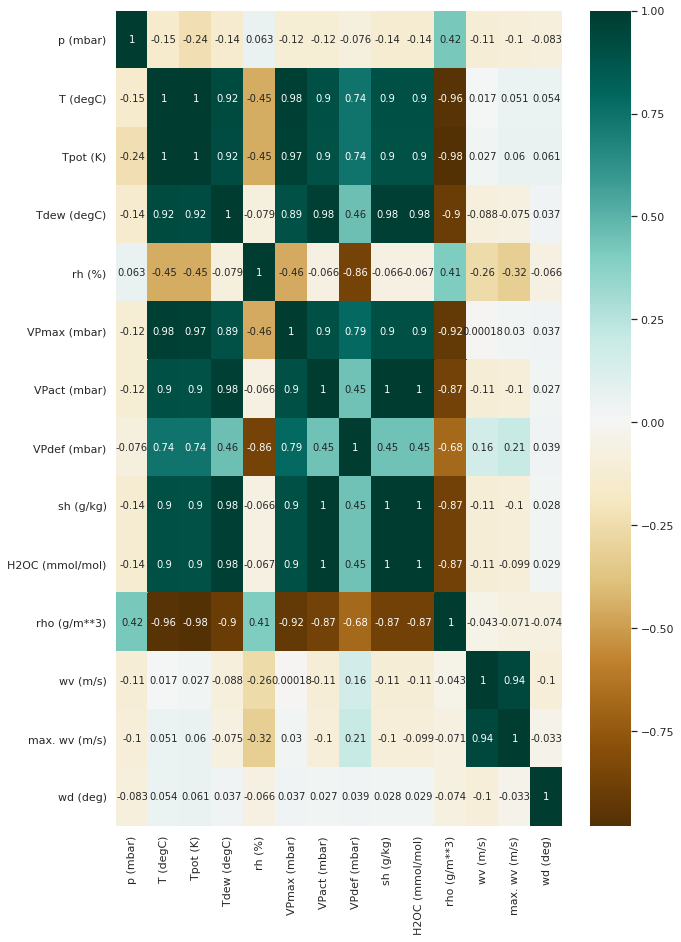

In [0]:
plt.figure(figsize=(10,15))
c= df.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c

In [0]:
tf.compat.v1.set_random_seed(10)   

In [0]:
temp = df['T (degC)']
temp.index = df['Date Time']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0963c32550>],
      dtype=object)

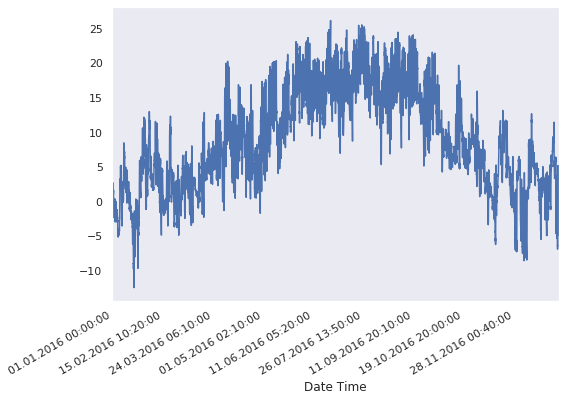

In [0]:
temp.plot(subplots=True)

Let us scale the temperature feature before we start training using basic normalization method

In [0]:
split_size = int(0.8*len(temp))
temp_data = temp.values
temp_train_mean = temp_data[:split_size].mean()
temp_train_std = temp_data[:split_size].std()
temp_data = (temp_data -temp_train_mean)/temp_train_std

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [0]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(temp_data, 0, split_size,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(temp_data, split_size, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [0]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.43497538]
 [-1.43214748]
 [-1.42507774]
 [-1.42366379]
 [-1.44063117]
 [-1.42366379]
 [-1.44063117]
 [-1.44628697]
 [-1.49153331]
 [-1.53112387]
 [-1.56788652]
 [-1.54526335]
 [-1.51698438]
 [-1.53536571]
 [-1.53819361]
 [-1.59899339]
 [-1.65555132]
 [-1.67676055]
 [-1.69231398]
 [-1.71210925]]

 Target temperature to predict
-1.6909000283683477


In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

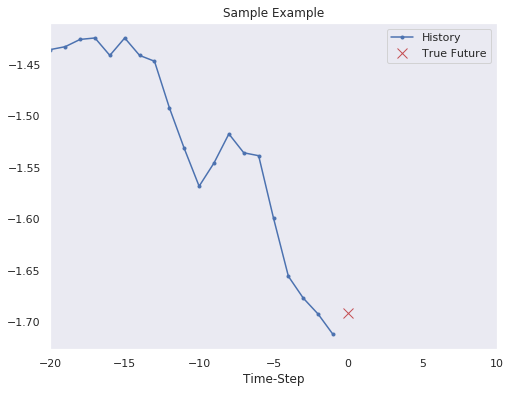

In [0]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [0]:
# use tf.data to shuffle data
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [0]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [0]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
200/200 [==============================] - 7s 36ms/step - loss: 0.2012 - val_loss: 0.0235
Epoch 2/10
200/200 [==============================] - 4s 22ms/step - loss: 0.0273 - val_loss: 0.0116
Epoch 3/10
200/200 [==============================] - 4s 22ms/step - loss: 0.0107 - val_loss: 0.0061
Epoch 4/10
200/200 [==============================] - 4s 22ms/step - loss: 0.0082 - val_loss: 0.0054
Epoch 5/10
200/200 [==============================] - 4s 22ms/step - loss: 0.0061 - val_loss: 0.0040
Epoch 6/10
200/200 [==============================] - 5s 23ms/step - loss: 0.0053 - val_loss: 0.0035
Epoch 7/10
200/200 [==============================] - 4s 22ms/step - loss: 0.0043 - val_loss: 0.0031
Epoch 8/10
200/200 [==============================] - 4s 22ms/step - loss: 0.0040 - val_loss: 0.0028
Epoch 9/10
200/200 [==============================] - 4

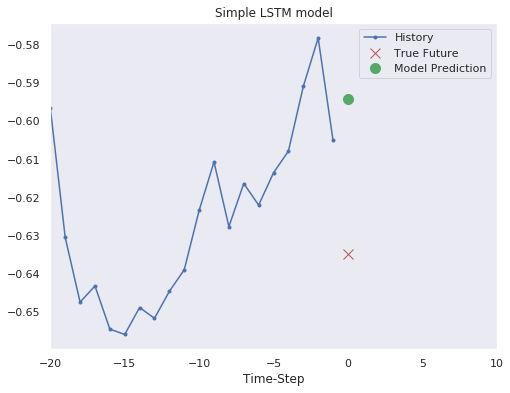

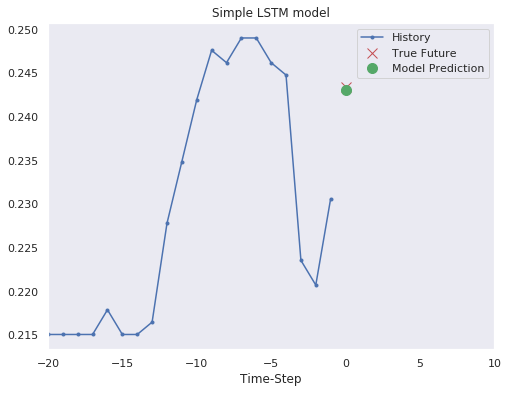

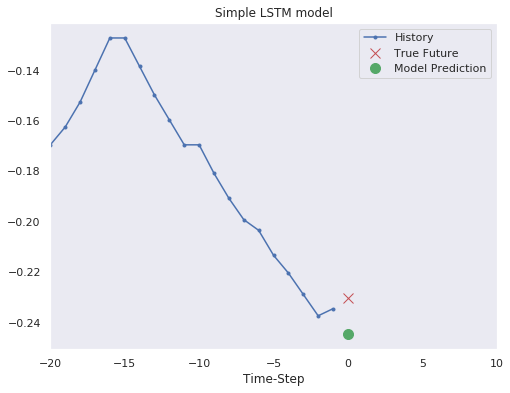

In [0]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

Multivariate time forecasting

In [0]:
features = ['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']

In [0]:
dataset = df[features]
dataset.index = df['Date Time']
dataset.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
01.01.2016 00:00:00,999.08,-0.01,273.22,-0.44,96.9,6.10,5.91,0.19,3.69,5.92,1271.32,1.16,2.04,192.4
01.01.2016 00:10:00,999.03,0.01,273.25,-0.41,97.0,6.11,5.93,0.18,3.70,5.94,1271.16,1.01,2.12,211.6
01.01.2016 00:20:00,999.07,0.06,273.29,-0.36,97.0,6.13,5.95,0.18,3.71,5.96,1270.97,0.80,1.52,203.8
01.01.2016 00:30:00,999.09,0.07,273.30,-0.36,96.9,6.14,5.95,0.19,3.71,5.96,1270.93,0.77,1.64,184.2
01.01.2016 00:40:00,999.09,-0.05,273.18,-0.50,96.8,6.09,5.89,0.19,3.68,5.90,1271.54,0.84,1.92,200.1


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f09555185f8>,
      dtype=object)

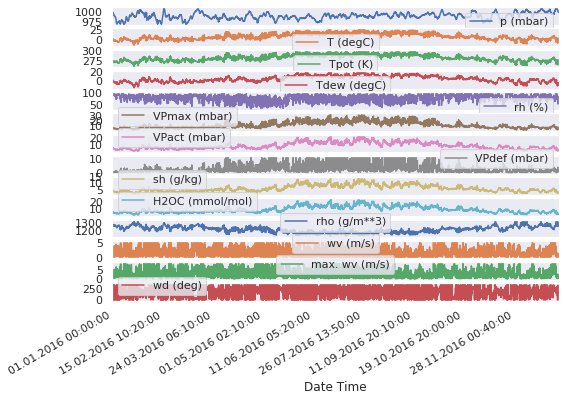

In [0]:
dataset.plot(subplots=True)

Again standardize the whole dataset

In [0]:
data = dataset.values
data_mean = data[:split_size].mean(axis=0)
data_std = data[:split_size].std(axis=0)
data = (data-data_mean)/data_std

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [0]:
past_history = 720 
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(data, data[:, 1], 0,
                                                   split_size, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(data, data[:, 1],
                                               split_size, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [0]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [0]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mean_squared_error')

In [0]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 44s 222ms/step - loss: 0.1944 - val_loss: 0.2909
Epoch 2/10
200/200 [==============================] - 42s 209ms/step - loss: 0.1121 - val_loss: 0.2436
Epoch 3/10
200/200 [==============================] - 42s 209ms/step - loss: 0.0935 - val_loss: 0.2890
Epoch 4/10
200/200 [==============================] - 41s 206ms/step - loss: 0.0786 - val_loss: 0.2829
Epoch 5/10
200/200 [==============================] - 41s 206ms/step - loss: 0.0654 - val_loss: 0.2580
Epoch 6/10
200/200 [==============================] - 41s 207ms/step - loss: 0.0593 - val_loss: 0.2833
Epoch 7/10
200/200 [==============================] - 41s 206ms/step - loss: 0.0500 - val_loss: 0.2868
Epoch 8/10
200/200 [==============================] - 41s 206ms/step - loss: 0.0466 - val_loss: 0.2463
Epoch 9/10
200/200 [==============================] - 41s 206ms/step - loss: 0.0410 - val_loss: 0.2410
Epoch 10/10
200/200 [=========

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

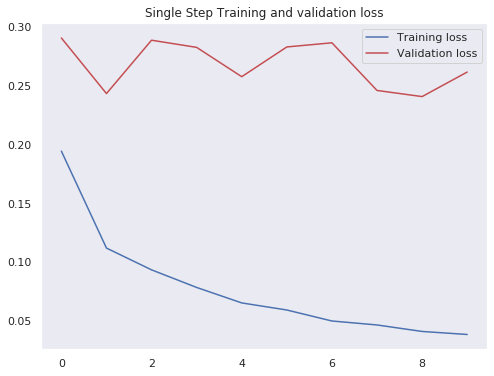

In [0]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

Plot prediction only for temperature

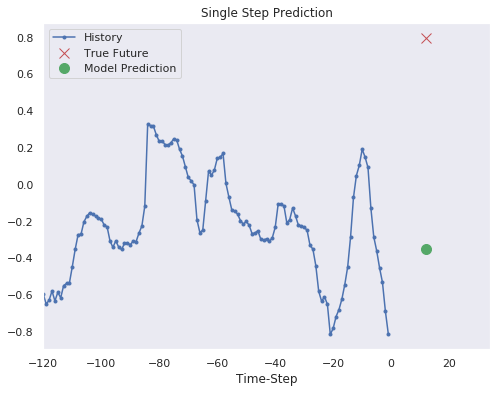

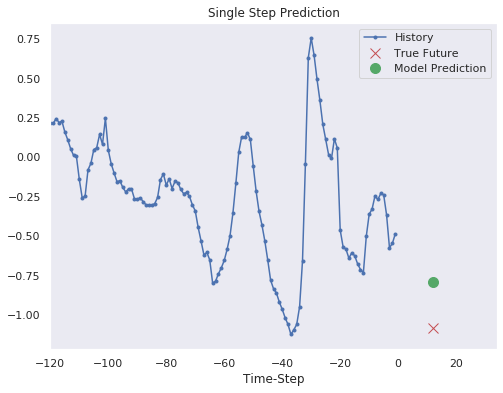

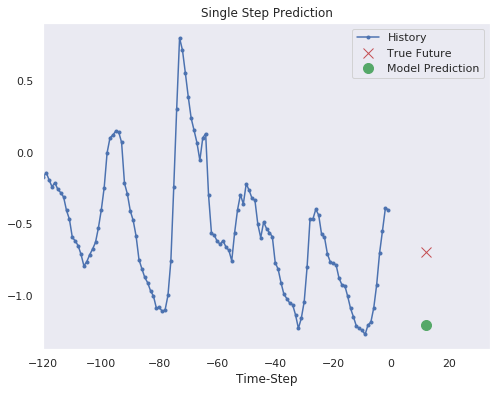

In [0]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

Multistep prediction

In [0]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(data, data[:, 1], 0,
                                                 split_size, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(data, data[:, 1],
                                             split_size, None, past_history,
                                             future_target, STEP)

In [0]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 14)

 Target temperature to predict : (72,)


In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

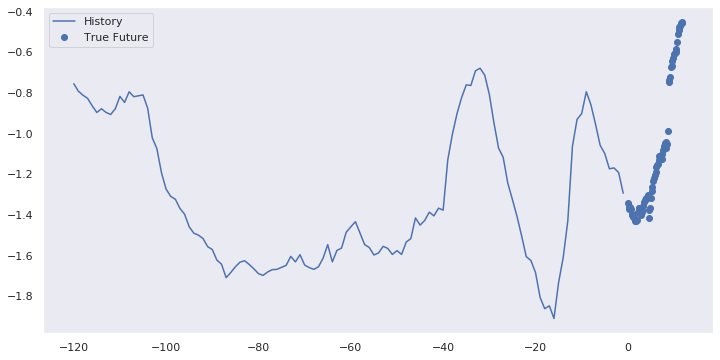

In [0]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [0]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mean_squared_error')

In [0]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 81s 403ms/step - loss: 155864.8924 - val_loss: 0.9337
Epoch 2/10
200/200 [==============================] - 76s 379ms/step - loss: 0.7159 - val_loss: 0.8991
Epoch 3/10
200/200 [==============================] - 75s 377ms/step - loss: 0.4604 - val_loss: 0.4251
Epoch 4/10
200/200 [==============================] - 75s 377ms/step - loss: 77.4629 - val_loss: 0.3457
Epoch 5/10
200/200 [==============================] - 75s 376ms/step - loss: 0.2785 - val_loss: 0.3425
Epoch 6/10
200/200 [==============================] - 75s 375ms/step - loss: 0.2725 - val_loss: 0.3709
Epoch 7/10
200/200 [==============================] - 75s 375ms/step - loss: 110523518.3567 - val_loss: 608625046.0670
Epoch 8/10
200/200 [==============================] - 75s 374ms/step - loss: 78973082.5921 - val_loss: 993379627.9200
Epoch 9/10
200/200 [==============================] - 75s 374ms/step - loss: 10378993.4406 - val

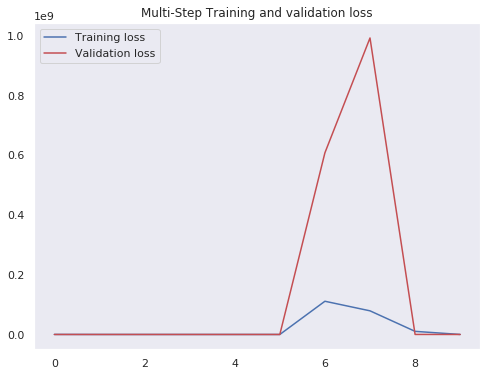

In [0]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

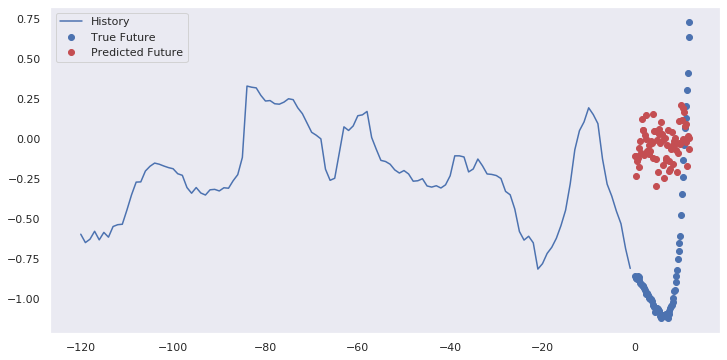

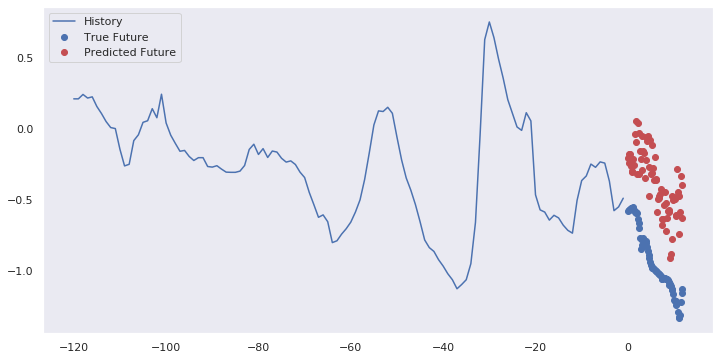

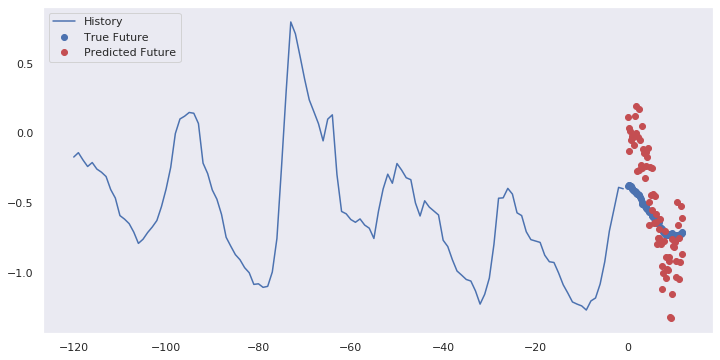

In [0]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])